# Brain age regression
#### Two main approachs, with all the data from all the runs and the other with the mean matrix correlation for each subject
# 1. Importing all data or Fisher transformed

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [36]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [37]:
df, phenotypic = import_data(fisher=False)

In [38]:
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')
df = ((df.reset_index()).drop(columns=['Institution', 'Subject','Run'])).dropna(subset=[str(x) for x in range(0,61425)])


## 2. Starting modelling

#### Linear Regression

In [39]:
df

,0,1,2,3,4,5,6,7,8,9,...,61418,61419,61420,61421,61422,61423,61424,Age,ADHD Measure,Gender
0,-0.357395,0.227763,-0.332295,-0.246257,-0.035910,-0.190166,-0.060984,-0.187900,-0.148917,-0.289987,...,-0.061142,-0.447198,-0.103163,0.152626,0.081389,-0.097951,-0.063706,12.36,2.0,0.0
1,-0.404978,0.262990,-0.477841,-0.230924,-0.046985,-0.226501,-0.052673,-0.285175,-0.171859,-0.317749,...,-0.225724,-0.110544,0.050810,0.103340,0.116743,0.004726,-0.107168,12.36,2.0,0.0
2,-0.037248,-0.017628,-0.134596,-0.263412,-0.243365,0.183201,-0.118924,-0.241377,0.322071,-0.028328,...,-0.210936,-0.117962,0.003530,0.197735,0.175436,0.272861,-0.020862,12.98,2.0,1.0
3,-0.042442,-0.095684,-0.139512,-0.138527,-0.214809,0.207912,-0.193584,-0.231468,0.335456,0.057406,...,-0.307595,-0.131026,-0.008978,0.070941,0.070116,0.332188,-0.181075,12.98,2.0,1.0
4,-0.145595,-0.055954,-0.301416,0.067386,0.567353,-0.081181,-0.172798,-0.259437,-0.216941,0.410270,...,-0.193758,0.164700,-0.266266,0.220429,0.338484,0.124556,-0.328805,9.12,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,0.005095,-0.177230,-0.231547,0.336425,0.204110,0.259284,0.430903,-0.066652,-0.000092,0.176039,...,0.143245,0.197795,0.136882,-0.158320,-0.041907,0.059261,-0.083142,12.88,NaN,1.0
2392,-0.029288,-0.265618,-0.557456,0.147477,-0.041983,-0.242834,0.524965,-0.373814,-0.171160,-0.203096,...,0.224912,-0.143121,0.114985,0.063457,-0.241751,-0.256948,-0.369872,12.88,NaN,1.0
2393,-0.002890,-0.251487,-0.525651,0.109587,-0.060068,-0.119969,0.476250,-0.310759,-0.038912,-0.188009,...,0.088147,-0.014411,0.010242,-0.029106,-0.071946,-0.102806,-0.411572,12.88,NaN,1.0
2394,0.057347,-0.416736,-0.438971,0.186793,-0.246174,-0.178381,0.140341,-0.130582,-0.158882,-0.240096,...,0.115776,-0.038916,0.211471,0.133843,-0.048274,-0.087996,-0.245618,12.88,NaN,1.0


In [40]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-3]
y = df.Age

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [41]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
y_pred = reg.predict(X_test)

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.8188413556028965

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, X, y, cv=5,scoring='neg_mean_absolute_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-1.86 accuracy with a standard deviation of 0.34


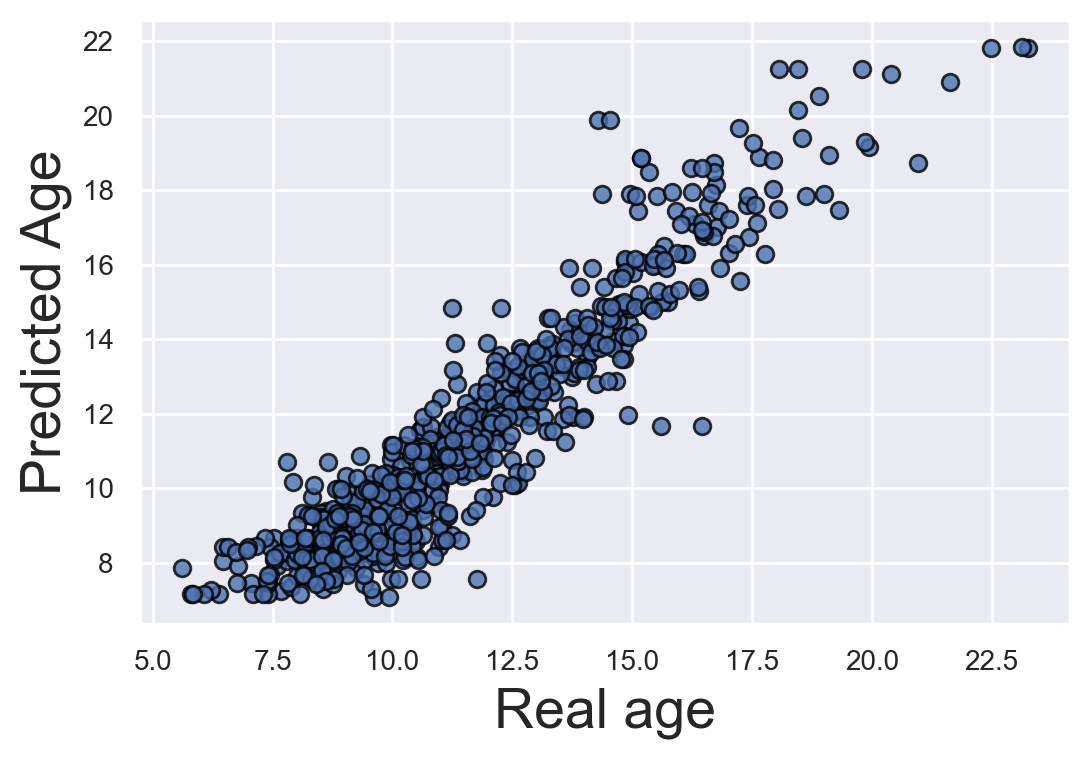

In [44]:
plt.figure(dpi=200)
plt.scatter(y_pred,y_test,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.show()

### Lasso regularization

In [4]:
from sklearn import linear_model
reg_reg = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [16]:

reg_reg.score(X_test, y_test)
y_pred = reg_reg.predict(X_test)

In [17]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

1.92920465371593

In [40]:
from sklearn.model_selection import GridSearchCV

reg_reg = linear_model.Lasso()

alpha_range = [0.0001,0.0005,0.001]
param_grid =  dict(alpha = alpha_range)

grid = GridSearchCV(reg_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True,verbose=1)
grid_search=grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/envs/core/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.415745810647383, tolerance: 1.3905488186195014
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/core/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.497408857951394, tolerance: 1.4203917210901469
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/core/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.4290598582827

In [41]:
print(grid_search.best_params_)

{'alpha': 0.001}


In [42]:
accuracy = grid_search.best_score_
print("mean absolute error : {:.2f}".format(accuracy) )

mean absolute error : -1.08


In [43]:
grid_search.cv_results_

{'mean_fit_time': array([ 45.1033627 ,  43.32983479, 188.05889025]),
 'std_fit_time': array([  0.75982295,   0.69599101, 289.24080189]),
 'mean_score_time': array([0.18729806, 0.19035358, 0.19015899]),
 'std_score_time': array([0.00321262, 0.01079444, 0.00713674]),
 'param_alpha': masked_array(data=[0.0001, 0.0005, 0.001],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001}, {'alpha': 0.0005}, {'alpha': 0.001}],
 'split0_test_score': array([-1.1977264 , -1.1126391 , -1.12106127]),
 'split1_test_score': array([-1.06178463, -1.0435887 , -1.02210944]),
 'split2_test_score': array([-1.08885475, -1.09032492, -1.1043195 ]),
 'split3_test_score': array([-1.04325176, -1.04459084, -1.03178899]),
 'split4_test_score': array([-1.14588362, -1.11904398, -1.10293272]),
 'mean_test_score': array([-1.10750023, -1.08203751, -1.07644238]),
 'std_test_score': array([0.05688494, 0.03241969, 0.04102612]),
 'rank_test_score': array([3, 

### After fiding the best hyper-parameter

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg_reg = linear_model.Lasso(alpha=0.001).fit(X_train, y_train)
y_pred = reg_reg.predict(X_test)

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.3942847797563889
3.072083922281033


/opt/homebrew/Caskroom/miniforge/base/envs/core/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2342589407090285, tolerance: 0.2279000454545454
  model = cd_fast.enet_coordinate_descent(


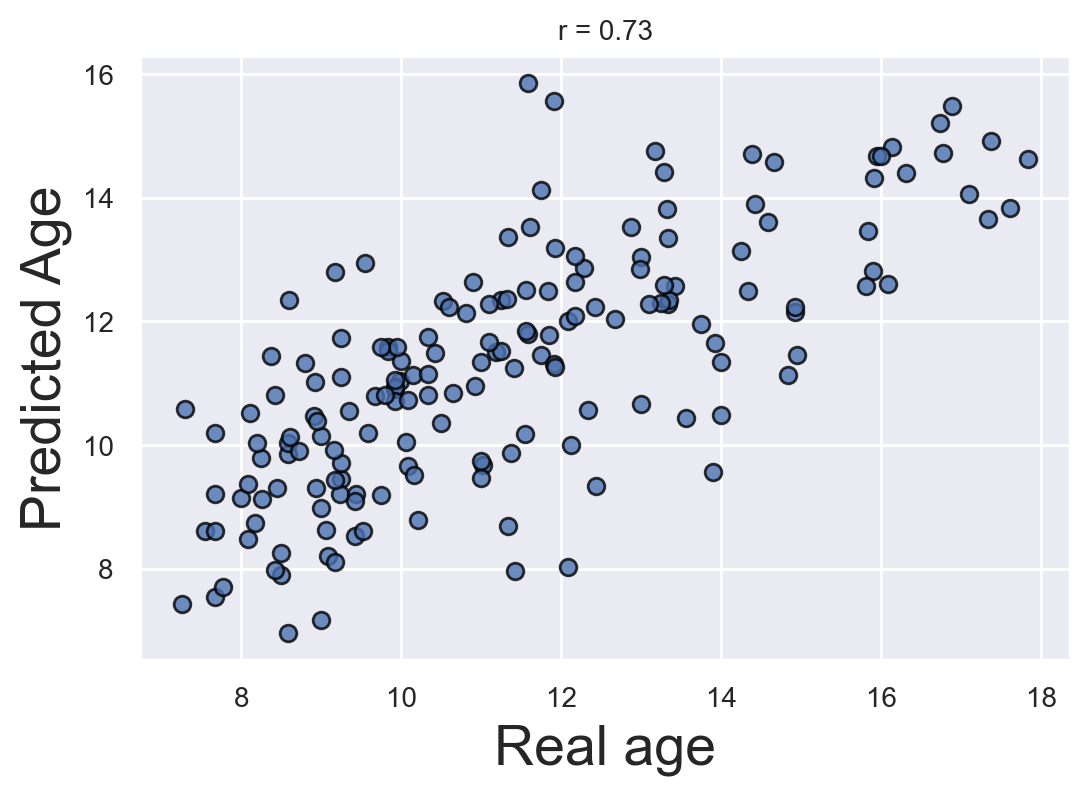

In [144]:
plt.figure(dpi=200)
plt.scatter(y_test,y_pred,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.title(('r = {:.2f}'.format(np.corrcoef(y_test,y_pred)[0,1])))
plt.show()

In [129]:
df_aux = df.loc[list(y_test.index),:]
df_aux['Predicted Age'] = y_pred

<AxesSubplot:xlabel='Age', ylabel='Predicted Age'>

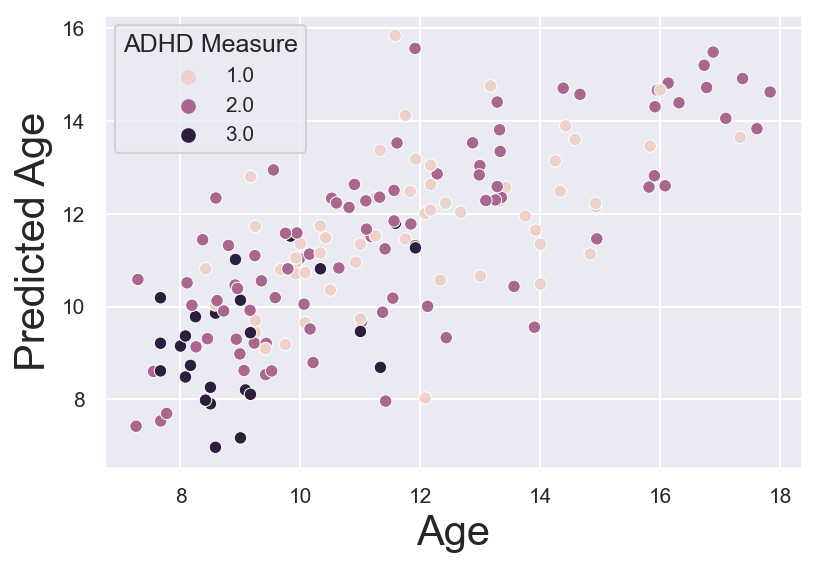

In [135]:
plt.figure(dpi=150)
sns.scatterplot(data=df_aux, x='Age', y='Predicted Age', hue='ADHD Measure')

## Pycaret

### PCA

In [5]:
# from sklearn.decomposition import PCA


# # PCA
# pca = PCA(n_components=100)
# XPCA_train = pca.fit_transform(X_train)
# XPCA_test = pca.fit_transform(X_test)

In [6]:
# XPCA_train = pd.DataFrame(XPCA_train)
# XPCA_train['Age'] = y_train.values
# XPCA_train = XPCA_train.dropna()

# XPCA_test = pd.DataFrame(XPCA_test)
# XPCA_test['Age'] = y_test.values
# XPCA_test = XPCA_test.dropna()

In [ ]:
from pycaret.regression import *
s = setup(df, target = 'Age')

In [8]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.4086,3.3359,1.8219,0.6735,0.1395,0.1242,0.1900
et,Extra Trees Regressor,1.5484,3.8692,1.9649,0.6217,0.1518,0.1392,0.2880
br,Bayesian Ridge,1.5489,3.9282,1.9776,0.6154,0.1635,0.1385,0.0060
lr,Linear Regression,1.5568,3.9614,1.9859,0.6117,0.1638,0.1398,0.3220
ridge,Ridge Regression,1.5568,3.9613,1.9859,0.6117,0.1638,0.1398,0.0040
lar,Least Angle Regression,1.5568,3.9614,1.9859,0.6117,0.1638,0.1398,0.0050
huber,Huber Regressor,1.5403,4.0177,1.9996,0.6068,0.1614,0.1366,0.0150
xgboost,Extreme Gradient Boosting,1.5348,4.1325,2.0259,0.5959,0.1563,0.1363,0.4920
gbr,Gradient Boosting Regressor,1.6316,4.2671,2.0622,0.5837,0.1582,0.1446,0.5990
knn,K Neighbors Regressor,1.6192,4.3668,2.0876,0.5712,0.1638,0.1480,0.0100


In [10]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [9]:
bayesian_bridge = create_model('br') 
tuned_bayesian_bridge = tune_model(bayesian_bridge)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.6658,4.2578,2.0634,0.5711,0.1666,0.1512
1,1.6958,5.2148,2.2836,0.4790,0.2467,0.1553
2,1.4547,3.3245,1.8233,0.5452,0.1509,0.1375
3,1.4244,3.2533,1.8037,0.6992,0.1429,0.1252
4,1.4894,3.8910,1.9725,0.6241,0.1528,0.1296
5,1.4932,3.6891,1.9207,0.6702,0.1457,0.1301
6,1.5380,3.6971,1.9228,0.6553,0.1483,0.1331
7,1.5342,3.8791,1.9695,0.6516,0.1635,0.1384
8,1.6383,4.2893,2.0711,0.5731,0.1649,0.1483
9,1.5544,3.7855,1.9456,0.6847,0.1525,0.1361


In [14]:
predictions = predict_model(tuned_bayesian_bridge)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.0176,14.5265,3.8114,-0.4822,0.3192,0.2792


In [15]:
predictions.shape

(710, 102)

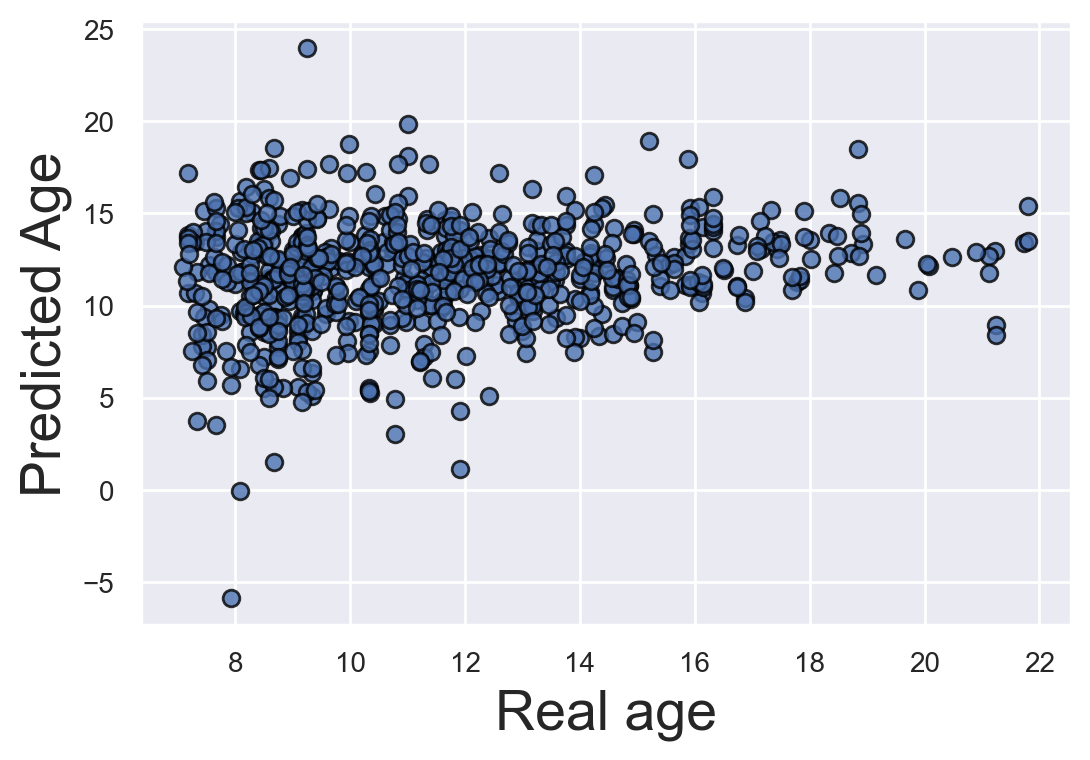

In [16]:
plt.figure(dpi=200)
plt.scatter(predictions.Age,predictions.Label,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.show()